                                ENTRENAMIENTO DE ROBOTS - PARCIAL #4 - MÉTODOS COMPUTACIONALES - GABRIEL BORRERO Y CATALINA FLÓREZ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy
from tqdm import tqdm

# Neural stuff

In [3]:
sigm = lambda x: 1/(1+np.exp(-x))

(f) Elija un mutation rate adecuado para que cada cerebro pueda cambiar sus
 parametros y bajar la funcion de aptitud.

In [4]:
class Layer:
    
    
    def __init__(self,NC,NN,ActFun,rate=0.2): # 0.2 Es un muy buen número, nos da muchos robots inteligentes
        
        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate
        
        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )
        
    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]
    
    def Mutate(self):
    
        #self.W += np.random.normal( loc=0., scale=self.rate, size=(self.NC,self.NN))
        #self.b += np.random.normal( loc=0., scale=self.rate, size=(1,self.NN))
        
        self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))

    def setW(self, NW):
        self.W = NW
    
    def setB(self, NB):
        self.b = NB

 (c) Usando la clase Layer defina una red con 1 neurona en la capa de entrada, 5 neuronas en la capa oculta y 1 neurona en la capa de salida. La red debe recibir la posicion del robot como entrada y la salida es un numero entre 0 y 1 para decidir si se invierte el vector velocidad. (Parte 1)

In [5]:
def GetBrain():
    l0 = Layer(1,5,sigm)
    l0.W
    #L1 = capa de salida
    l1 = Layer(5,1,sigm)
    Brain = [l0,l1]
    return Brain    

In [6]:
GetBrain()[1].b

array([[-2.81014685]])

# Estructura del individuo

(c) Si la activacion es mayor a 0.7 se invierte el vector de velocidad. Usted puede elegir una topologa de red mas compleja. (Parte 2)

 (d) Defina un atributo de clase: self.Steps, este atributo controla qué tanto avanza el robot en la region de interés. (Parte 1)

(e) La función de aptitud de este problema puede definirse como el inverso del número de pasos que el robot puede hacer sin salir de la función de interés. P = 1/Nsteps . Esto significa que, si hay aprendizaje el robot puede avanzar rebotando en los límites de la región. Usted puede pensar en otra función de optimización para resolver el problema.

 (g) En la clase Robot, defina un método que haga el forward pass de la red, si la activación es mayor a 0.7 invierta el vector velocidad self.v =-self.v.

In [7]:
class Robot:
    
    def __init__(self, dt, Layers, Id=0):
        
        self.Id = Id
        self.dt = dt
        
        
        self.r = np.random.uniform([0.,0.])
        theta = 0.
        self.v = np.array([1.*np.cos(theta),1.*np.sin(theta)])

        
        # Capacidad o aptitud del individuo
        self.Fitness = np.inf
        #D
        self.Steps = 0

        # Brain
        self.Layers = Layers
        
    def GetR(self):
        return self.r
    
    def Evolution(self):
        self.r += self.v*self.dt # Euler integration (Metodos 2)

        # Cada generación regreamos el robot al origin
        # Y volvemos a estimar su fitness
    def Reset(self):
        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf    
        
    # Aca debes definir que es mejorar en tu proceso evolutivo
    def SetFitness(self):
        self.Fitness = 1/self.Steps 
        
       # Brain stuff
    def BrainActivation(self,x,threshold=0.70): # 0.7 Es un muy buen número
        # El umbral (threshold) cerebral es a tu gusto!
        # cercano a 1 es exigente
        # cercano a 0 es sindrome de down
        
        # Forward pass - la infomación fluye por el modelo hacia adelante
        for i in range(len(self.Layers)):         
            if i == 0:
                output = self.Layers[i].Activation(x)
            else:
                output = self.Layers[i].Activation(output)
        
        self.Activation = np.round(output,4)
    
        # Cambiamos el vector velocidad
        #C & E
        if self.Activation[0] > threshold:
            self.v = -self.v
            self.Steps -= 0.5
            
            # Deberias penalizar de alguna forma, dado que mucha activación es desgastante!
            # Para cualquier cerebro
    
        return self.Activation
    
    # Aca mutamos (cambiar de parametros) para poder "aprender"
    def Mutate(self):
        for i in range(len(self.Layers)):
            self.Layers[i].Mutate()
    
    # Devolvemos la red neuronal ya entrenada
    def GetBrain(self):
        return self.Layers

In [8]:
def GetRobots(N):
    
    Robots = []
    
    for i in range(N):
        
        Brain = GetBrain()
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)
        
    return Robots

(b) La evolución temporal de la simulación debe estar entre 0 a 5 segundos, con un intervalo temporal de t = 0.1 s

In [9]:
dt = 0.1
t = np.arange(0.,5.,dt)

(a) Genere al menos N = 200 robots.

In [10]:
Robots = GetRobots(200)

In [11]:
def GetPlot():
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
 
    return ax,ax1

# Time evolution

(d) Durante el movimiento el robot aumenta el valor
 de esta variable en una unidad si la partícula se encuentra entre -1<=x<=1. Note que si la red se activa demasiado cambiará constantemente el vector velocidad y no podrá avanzar (overfitting), deberá penalizar este cambio disminuyendo la variable self.Steps en cierto factor entre ([0.0, 0.9]) para que el fitness no disminuya con un modelo muy activo.(Parte 2)

In [12]:
def TimeEvolution(Robots,e,Plot=True):
    
  
    for it in range(t.shape[0]):
        
        if Plot:
        
            clear_output(wait=True)
        
            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)
        
            ax.set_title('t = {:.3f}'.format(t[it]))
        
        Activation = np.zeros(len(Robots))
        
        for i,p in enumerate(Robots):
            p.Evolution()
         
            # Activacion cerebral
            Act = p.BrainActivation(p.GetR()[0])
            Activation[i] = Act
            # Region donde aumentamos los pasos para el fitness
            #D
            if -1<=p.GetR()[0] and p.GetR()[0]<=1:
                p.Steps += 1
            
            if Plot and i < 5: # Solo pintamos los primeros 5, por tiempo de computo
                ax.scatter(p.r[0],p.r[1],label='Id: {}, Steps: {:.0f}'.format(p.Id,p.Steps))
                ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])
                
        # Pintamos la activaciones de los primeros 5
        
        if Plot:
            ax1.plot(np.arange(0,len(Robots[:5]),1),Activation[:5],marker='o',color='b',label='Activation')
            ax1.axhline(y=0.7,color='r')
        
        if Plot:
        
            ax.legend(loc=0)  
            ax1.legend(loc=0)
            plt.show()
            time.sleep(0.001)

# Algoritmo evolutivo

(h) La pseudo-rutina de 200 épocas

In [13]:
# Definimos la rutina de entrenamiento
def Genetic(Robots, epochs = 200, Plot = True, Plottime=False):
    
    # Porcentaje de robots elegidos en cada epoch
    N = int(0.7*len(Robots))
    
    FitVector = np.array([])
    
    
    x = np.linspace(-1,1,20)
    Act = np.zeros_like(x)
    
    for e in range(int(epochs)):
        
        # Reiniciamos y mutamos los pesos
        
        for p in Robots:
            p.Reset() 
            p.Mutate()
            
        # Evolucionamos
        TimeEvolution(Robots,e,Plottime) # Apagar dibujar la evolución para entrenar
        
        # Actualizamos fitness de cada robot
        for i,p in enumerate(Robots):
            p.SetFitness()
        
        # Aca va toda la rutina de ordenar los bots del más apto al menos apto
        
        scores = [ (p.Fitness,p) for p in Robots ]
        scores.sort(key = lambda x: x[0])
        best_fitness = scores[0][0] #Aquí encontramos el mejor fitness, el cual se encuentra al principio de la matriz
        best_bot = scores[0][1] #Aquí encontramos al mejor robor, el cual se encuentra al principio de la matriz
        
        FitVector = np.append(FitVector,best_fitness)
        
        for i in range(len(x)):
            Act[i] = best_bot.BrainActivation(x[i])
        
        clear_output(wait=True)
        
        print('Epoch:', e)
                
        # Last fitness
        print('Last Fitness:', FitVector[-1])
        
        
        if Plot:
            
            ax,ax1 = GetPlot()
            ax.plot(x,Act,color='k')
            ax.set_ylim(0.,1)
            ax.axhline(y=0.7,ls='--',color='r',label='Threshold')
            
            ax1.set_title('Fitness')
            ax1.plot(FitVector)
        
            ax.legend(loc=0)
            
            plt.show()
            
            time.sleep(0.01)
        
        
    
    return best_bot, FitVector

Epoch: 199
Last Fitness: 0.021052631578947368


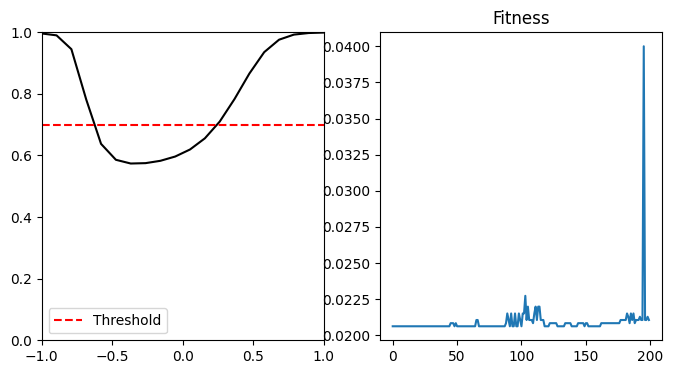

In [14]:
Robots = GetRobots(200)
best_bot, FitVector = Genetic(Robots,Plot=True,Plottime=False) # Apagar Plottime para el entrenamiento

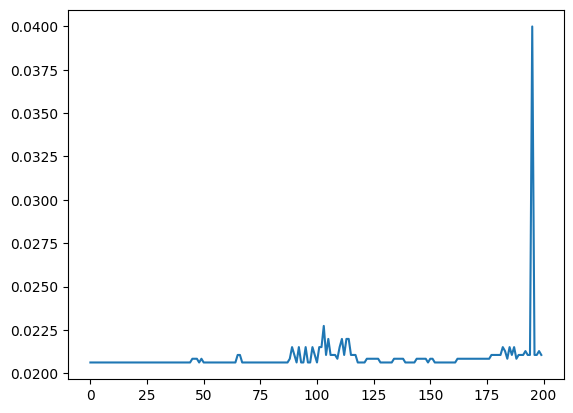

In [15]:
plt.plot(FitVector)

En este punto, nustro algoritmo grafica el robot más inteligente que nosotros encontramos previamente. Es decir, estos son nuestros mejores pesos y sesgos para las capas del cerebro más inteligente.

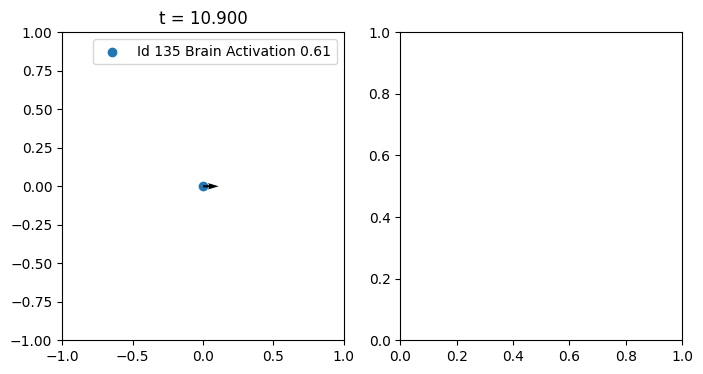

In [19]:
l0 = Layer(1,5,sigm)
l1 = Layer(5,1,sigm)


l0.setW(np.array([[ 2.78268061,  4.93261956, -7.17215435, 12.79291484,  8.53587976]]))
l0.setB(np.array([[-0.67335346,  3.21684754,  5.14525842,  0.74093667,  5.41793464]]))

l1.setW(np.array([[ -3.6179912],
 [0.50172628],
 [-5.39859062],
 [4.52230449],
 [-4.79656225]]))

l1.setB(np.array([[6.78601031]]))

Brain = [l0,l1]

trained = Robot(0.1,Brain,200)



dt = 0.1

t = np.arange(0.,11.,dt)


for lt in range(t.shape[0]):

    clear_output(wait=True)

    best_bot.Evolution()
    A = best_bot.BrainActivation(best_bot.GetR()[0])
    ax,_=GetPlot()
    ax.set_title('t = {:.3f}'.format(t[lt]))

    ax.scatter(best_bot.r[0],best_bot.r[1],label='Id {} Brain Activation {:.2f}'.format(best_bot.Id,A[0]))
    ax.quiver(best_bot.r[0],best_bot.r[1],best_bot.v[0],best_bot.v[1])

    ax.legend()
    plt.show()

    time.sleep(0.01)
    

Justo en este punto, nuestro algoritmo devuelve el mejor cerebro (el robot más inteligente que cumple con los requisitos del problema). Sin embargo, nustro algoritmo grafica el robot más inteligente que nosotros encontramos previamente. 

In [17]:
bestBrain = best_bot.GetBrain()
print("Neural Stuff associated with L0")
print("Weights: ",bestBrain[0].W)
print("Biasses: ",bestBrain[0].b)
print("Neural Stuff associated with L1")
print("Weights: ",bestBrain[1].W)
print("Biasses: ",bestBrain[1].b)


Neural Stuff associated with L0
Weights:  [[-5.79213319 12.67229988 -4.91890274  0.22925051  2.5197015 ]]
Biasses:  [[-8.85376104 10.19435593  3.87317621  8.18496256 -6.23023393]]
Neural Stuff associated with L1
Weights:  [[-0.38869186]
 [-5.75127408]
 [-9.15593367]
 [ 9.88800335]
 [ 1.52271746]]
Biasses:  [[5.26559461]]
